# GFlowNet Sequence Design Tutorial
This tutorial borrows heavily from Emanuelle Bengio's colab tutorial on GFlowNets: https://colab.research.google.com/drive/1fUMwgu2OhYpQagpzU5mhe9_Esib3Q2VR

In [2]:
import torch
from collections import OrderedDict
from src.models.gflownet_utils import (
    Vocab,
    FlowGenerator,
    compute_score_distribution,
    StandardDataset
)
import matplotlib.pyplot as pp
import numpy as np

In the following example, we work with an alphabet of DNA bases and the task is to generate high scoring DNA sequences.  
The alphabet is A, T, G, C which is encoded as 0, 1, 2, 3.  

Define a simple scoring function to test whether the GFlowNet policy is generating sequences in proportion to their score.

In [6]:
alphabet_set = OrderedDict(
    {
        "bases": [0, 1, 2, 3],
    }
)

# Get initial state
def score_func(protocol):

    state_1 = torch.tensor([[0], [1], [1]])
    state_2 = torch.tensor([[0], [0], [0]])
    state_3 = torch.tensor([[0], [3], [3]])

    match_1 = torch.all(protocol == state_1).item()
    match_2 = torch.all(protocol == state_2).item()
    match_3 = torch.all(protocol == state_3).item()

    if match_1:
        # print("Matched best state!")
        return 1

    elif match_2:
        # print("Matched second best state!")
        return 0.5

    elif match_3:
        # print("Matched third best state!")
        return 0.25

    else:
        return 1e-4


For simplicity, we will build sequences of length = 3. We now compute an expected score distribution based on all possible sequences that can be generated with this alphabet. This will be used later to check that the GFlowNet policy is indeed generating sequences proportional to their score.

In [8]:
seq_len = 3
vocab = Vocab(alphabet=alphabet_set)
num_tokens = vocab.num_tokens
init_sequence = OrderedDict({"bases": 0})
score_distribution, empirical_score_distribution, dataset_np, tensor_to_key = compute_score_distribution(
    alphabet_set, score_func, seq_len, init_sequence
)

gt = np.array(list(score_distribution.values()))

index = len(dataset_np) // 2
partial_dataset = StandardDataset(torch.from_numpy(dataset_np[:index]).float(), torch.from_numpy(gt[:index]).float())
full_dataset = StandardDataset(torch.from_numpy(dataset_np).float(), torch.from_numpy(gt).float())


Here we define the GFlowNet class and train it with half of the possible sequences.

In [10]:
gflownet = FlowGenerator(alphabet_set, seq_len, delta=0.1, verbose=False)
tb_losses, tb_mean_loss, logZs = gflownet.train(partial_dataset.x, score_func, num_episodes=10000)

100%|█| 10000/10000 [03:17<00:00, 50.54i


Compute sum of scores and plot loss and partition function.

Text(0, 0.5, 'mean loss')

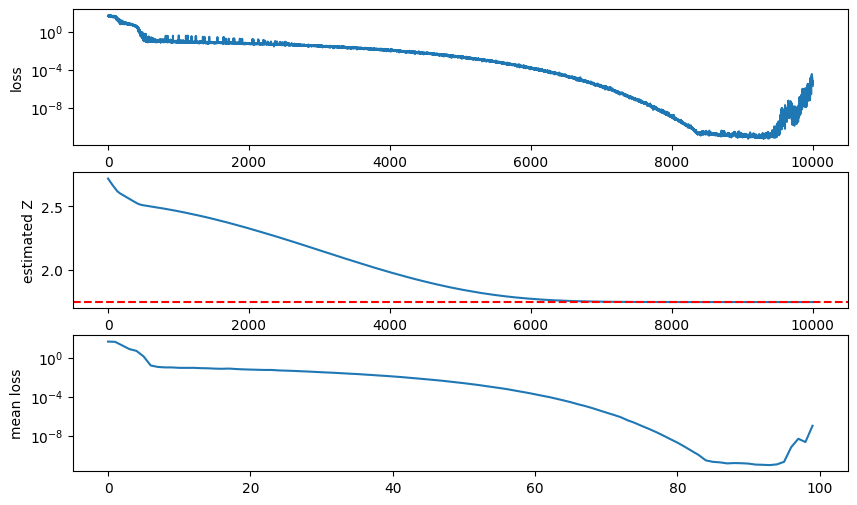

In [12]:
sum_scores = np.sum([score_func(protocol) for protocol in full_dataset.x])

f, ax = pp.subplots(3, 1, figsize=(10, 6))
pp.sca(ax[0])
pp.plot(tb_losses)
pp.yscale("log")
pp.ylabel("loss")

pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.axhline(sum_scores, color="red", linestyle="--")
pp.ylabel("estimated Z")
# pp.ylim(0, sum_rewards + 50)

pp.sca(ax[2])
pp.plot(tb_mean_loss)
pp.yscale("log")
pp.ylabel("mean loss")


As shown above, the estimated Z converges to the sum of all scores, indicating that the policy has found all possible scores during training.  
Now we check to make sure that policy samples sequences proportional to their score.

In [13]:
tb_sampled_protocols = gflownet.sample(sample_len=1000)

In [14]:
for gen_protocol in tb_sampled_protocols:
    if str(gen_protocol) in tensor_to_key:
        key = tensor_to_key[str(gen_protocol)]
        empirical_score_distribution[key] += 1
    else:
        print("Outside protocol!")


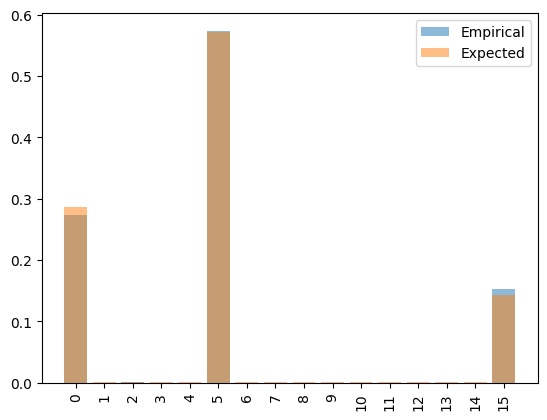

In [15]:
pp.bar(
    list(empirical_score_distribution.keys()),
    np.array(list(empirical_score_distribution.values())) / np.sum(list(empirical_score_distribution.values())),
    label="Empirical",
    alpha=0.5,
)
pp.bar(
    list(score_distribution.keys()),
    np.array(list(score_distribution.values())) / np.sum(list(score_distribution.values())),
    label="Expected",
    alpha=0.5,
)

pp.xticks(list(empirical_score_distribution.keys()), list(empirical_score_distribution.keys()), rotation="vertical")
pp.legend()

Success! The frequency of sequences, x, generated by the policy matches distribution
$$\pi(x) = S(x)/\sum_{x \in X} S(x)$$
where $S$ is the score of a sequence.